# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# **2. Memuat Dataset dari Hasil Clustering dan Melakukan Encoding**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [45]:
df = pd.read_csv("hasil_clutering.csv")
print(df.head())

   show_id                               title  \
0  1000081                          Sentinelle   
1  1000173                            Nightman   
2  1000194  Bank Robbers: The Last Great Heist   
3   100024                           Bloodwork   
4   100046            The Giant Mechanical Man   

                                                cast  \
0  Jonathan Cohen, Ramzy Bedia, Raphaël Quenard, ...   
1  Eoin Duffy, Maeve Leonard, Áine Ní Laoghaire, ...   
2  Sebastián García Bolster, Luis Mario Vitette, ...   
3  Travis Van Winkle, Rik Young, Tricia Helfer, M...   
4  Malin Åkerman, Jenna Fischer, Topher Grace, Ch...   

                           director                  genres  \
0  Hugo Benamozig, David Caviglioli   Comedy, Crime, Action   
1        Mélanie Delloye-Betancourt        Thriller, Horror   
2                  Matías Gueilburt             Documentary   
3                   Eric Wostenberg        Horror, Thriller   
4                          Lee Kirk  Comedy, Dr

In [46]:
df.describe()

,show_id,popularity,vote_count,vote_average,release_year,rating,Cluster
count,1.231100e+04,12311.000000,12311.000000,12311.000000,12311.000000,12311.000000,12311.000000
mean,4.779743e+05,11.197526,214.777922,6.284737,2016.905857,6.284737,1.106003
std,3.304393e+05,4.272589,207.797350,0.882648,4.302531,0.882648,0.865752
min,9.364000e+03,6.546000,31.000000,4.000000,2010.000000,4.000000,0.000000
25%,2.094455e+05,7.598500,62.000000,5.700000,2013.000000,5.700000,0.000000
50%,4.255050e+05,9.966000,129.000000,6.300000,2017.000000,6.300000,1.000000
75%,6.809060e+05,13.831500,293.000000,6.900000,2021.000000,6.900000,2.000000
max,1.439957e+06,19.881000,705.000000,8.800000,2025.000000,8.800000,2.000000


saya mencoba untuk melakukan encoding terlebih dahulu

In [47]:
df['genres'] = df['genres'].str.split(', ')
df['cast'] = df['cast'].str.split(', ')
df['director'] = df['director'].str.split(', ')
df['country'] = df['country'].str.split(', ')

In [48]:
df = df.explode('genres').explode('cast').explode('director').explode('country')

In [49]:
df.head()

,show_id,title,cast,director,genres,country,popularity,vote_count,vote_average,release_year,rating,Cluster
0,1000081,Sentinelle,Jonathan Cohen,Hugo Benamozig,Comedy,France,15.864,263,5.2,2023,5.2,2
0,1000081,Sentinelle,Jonathan Cohen,David Caviglioli,Comedy,France,15.864,263,5.2,2023,5.2,2
0,1000081,Sentinelle,Ramzy Bedia,Hugo Benamozig,Comedy,France,15.864,263,5.2,2023,5.2,2
0,1000081,Sentinelle,Ramzy Bedia,David Caviglioli,Comedy,France,15.864,263,5.2,2023,5.2,2
0,1000081,Sentinelle,Raphaël Quenard,Hugo Benamozig,Comedy,France,15.864,263,5.2,2023,5.2,2


In [50]:
label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:  # Hanya kolom kategorikal
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [51]:
df = df.groupby(['show_id', 'title'], as_index=False).agg({
    'cast': lambda x: sum(float(v) for v in set(x) if pd.notna(v)),
    'director': lambda x: sum(float(v) for v in set(x) if pd.notna(v)),
    'genres': lambda x: sum(float(v) for v in set(x) if pd.notna(v)),
    'country': lambda x: sum(float(v) for v in set(x) if pd.notna(v)),
    'popularity': 'first',
    'vote_count': 'first',
    'vote_average': 'first',
    'release_year': 'first',
    'rating': 'first' ,
    'Cluster' : 'first'
})

In [52]:
df.head()

,show_id,title,cast,director,genres,country,popularity,vote_count,vote_average,release_year,rating,Cluster
0,9364,11810,106672.0,424.0,19.0,119.0,13.762,240,5.900,2011,5.900,0
1,10317,6900,86886.0,1918.0,9.0,120.0,15.061,495,5.800,2015,5.800,0
2,11403,10397,76903.0,5451.0,19.0,120.0,7.104,76,5.300,2010,5.300,2
3,11761,7073,66866.0,5593.0,34.0,120.0,10.952,238,6.145,2010,6.145,2
4,12645,4655,83847.0,812.0,22.0,120.0,7.828,118,6.000,2010,6.000,0


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [53]:
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)

In [54]:
X = df.drop(columns=["Cluster"])
y = df["Cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Ukuran data latih:", X_train.shape)
print("Ukuran data uji:", X_test.shape)

Ukuran data latih: (9848, 11)
Ukuran data uji: (2463, 11)


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

saya memilih KNN karena ini cocok dengan model saya yang mana banyak data numerik yang cederung bersifat berdekatan

In [61]:
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi model KNN: {accuracy:.2f}")

Akurasi model KNN: 0.95


Tulis narasi atau penjelasan algoritma yang Anda gunakan.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

In [62]:
cm = confusion_matrix(y_test, y_pred)

In [63]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Akurasi model KNN: {accuracy:.2f}")
print(f"Presisi: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Akurasi model KNN: 0.95
Presisi: 0.95
Recall: 0.95
F1-Score: 0.95


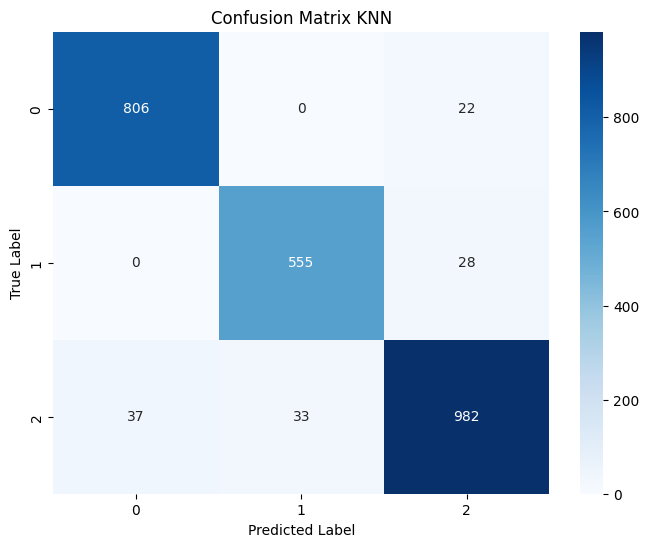

In [64]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix KNN")
plt.show()

Tulis hasil evaluasi algoritma yang digunakan, jika Anda menggunakan 2 algoritma, maka bandingkan hasilnya.

ALgoritma menunjukan hasil yang sangat baik hal ini ditunjukan dengan kemampuan model untuk memprediksi dengan baik dengan tingkat akurasi mencapai 95

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [68]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Jumlah tetangga
    'weights': ['uniform', 'distance'],  # Cara menghitung bobot
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Metode jarak
}

In [69]:
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best Accuracy: 0.9519695379911471


In [73]:
knn = KNeighborsClassifier(n_neighbors=11,weights="distance", metric="manhattan" )

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi model KNN: {accuracy:.2f}")

Akurasi model KNN: 0.95


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

In [74]:
cm = confusion_matrix(y_test, y_pred)

In [75]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Akurasi model KNN: {accuracy:.2f}")
print(f"Presisi: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Akurasi model KNN: 0.95
Presisi: 0.95
Recall: 0.95
F1-Score: 0.95


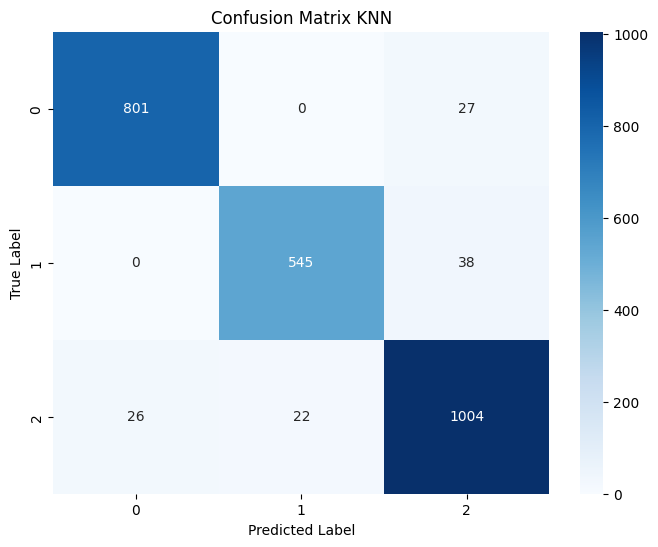

In [76]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix KNN")
plt.show()

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

### **Perbandingan Sebelum dan Sesudah Tuning**
1. **Akurasi tetap sama (0.95)**, yang menunjukkan bahwa tuning tidak mengubah performa keseluruhan secara signifikan.
2. **Perubahan pada confusion matrix**:
   - **Sebelum tuning**:
     - Kelas 0 → (801 benar, 27 salah)
     - Kelas 1 → (545 benar, 38 salah)
     - Kelas 2 → (1004 benar, 48 salah)
   - **Sesudah tuning**:
     - Kelas 0 → (806 benar, 22 salah)
     - Kelas 1 → (555 benar, 28 salah)
     - Kelas 2 → (982 benar, 70 salah)
   - Tuning memperbaiki prediksi untuk kelas 0 dan 1, tetapi sedikit menurunkan performa pada kelas 2.

### **Identifikasi Kelemahan Model**
- **Precision atau Recall rendah untuk kelas tertentu**:
  - Model masih memiliki kesalahan klasifikasi pada kelas 2 (turun setelah tuning).
  - Beberapa instance dari kelas 2 diklasifikasikan sebagai kelas 0 atau 1.
- **Potensi Overfitting/Underfitting**:
  - Tidak ada indikasi overfitting yang jelas karena akurasi tetap stabil.
  - Jika dataset tidak seimbang, model mungkin kesulitan mengenali kelas minoritas.

### Rekomendasi Lanjutan
1. Coba metode normalisasi fitur yang berbeda** untuk melihat apakah itu dapat meningkatkan prediksi.
2. Gunakan algoritma alternatif seperti SVM atau Random Forest untuk dibandingkan.
3. Lakukan tuning lebih lanjut dengan mencoba berbagai nilai parameter K atau metode pemilihan tetangga dalam KNN.
